In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
# Step 1: Download Stock Data
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(stocks, start="2018-01-01", end="2024-01-01")

# Step 2: Prepare the Data
data_close = data['Close']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

[*********************100%%**********************]  5 of 5 completed


In [13]:
# Create sequences for LSTM
def create_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

time_step = 30# 60 days look-back
X_train, Y_train = create_sequences(train_data, time_step)
X_test, Y_test = create_sequences(test_data, time_step)

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(stocks))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(stocks))

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(stocks))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(stocks)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)


Epoch 1/10


/Users/faidhi/Documents/Programming Training/WQU Capstone/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 - 1s - 33ms/step - loss: 0.0409
Epoch 2/10
37/37 - 0s - 9ms/step - loss: 0.0112
Epoch 3/10
37/37 - 0s - 9ms/step - loss: 0.0090
Epoch 4/10
37/37 - 0s - 9ms/step - loss: 0.0078
Epoch 5/10
37/37 - 0s - 9ms/step - loss: 0.0067
Epoch 6/10
37/37 - 0s - 9ms/step - loss: 0.0065
Epoch 7/10
37/37 - 0s - 9ms/step - loss: 0.0061
Epoch 8/10
37/37 - 0s - 9ms/step - loss: 0.0057
Epoch 9/10
37/37 - 0s - 9ms/step - loss: 0.0052
Epoch 10/10
37/37 - 0s - 9ms/step - loss: 0.0054


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE for AAPL: 300.7880


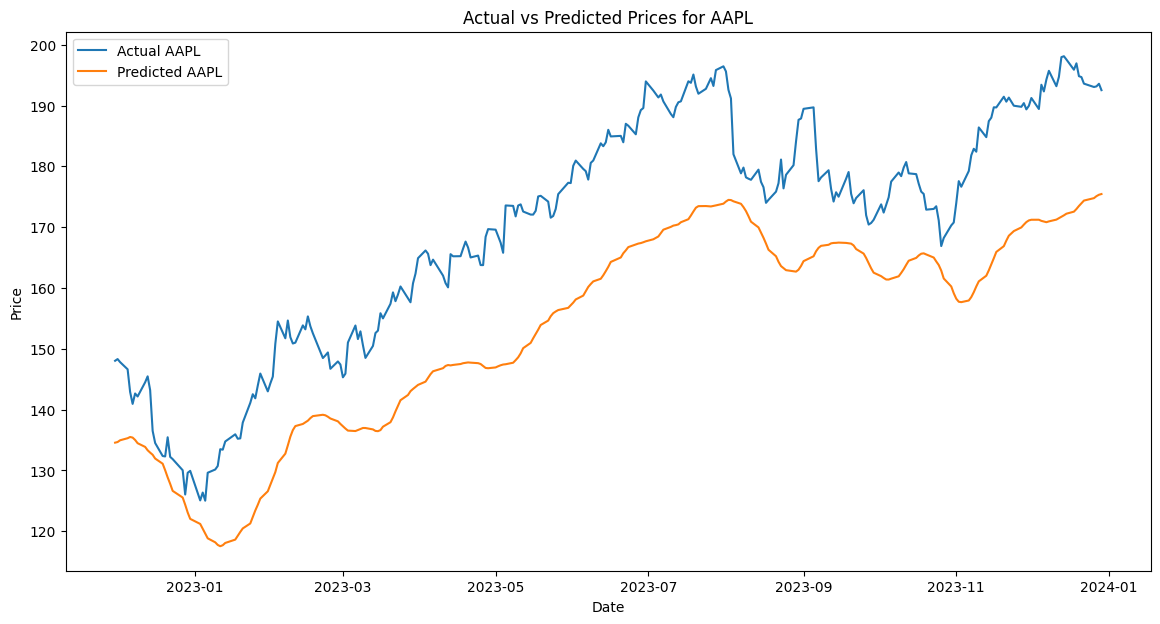

MSE for MSFT: 59.0305


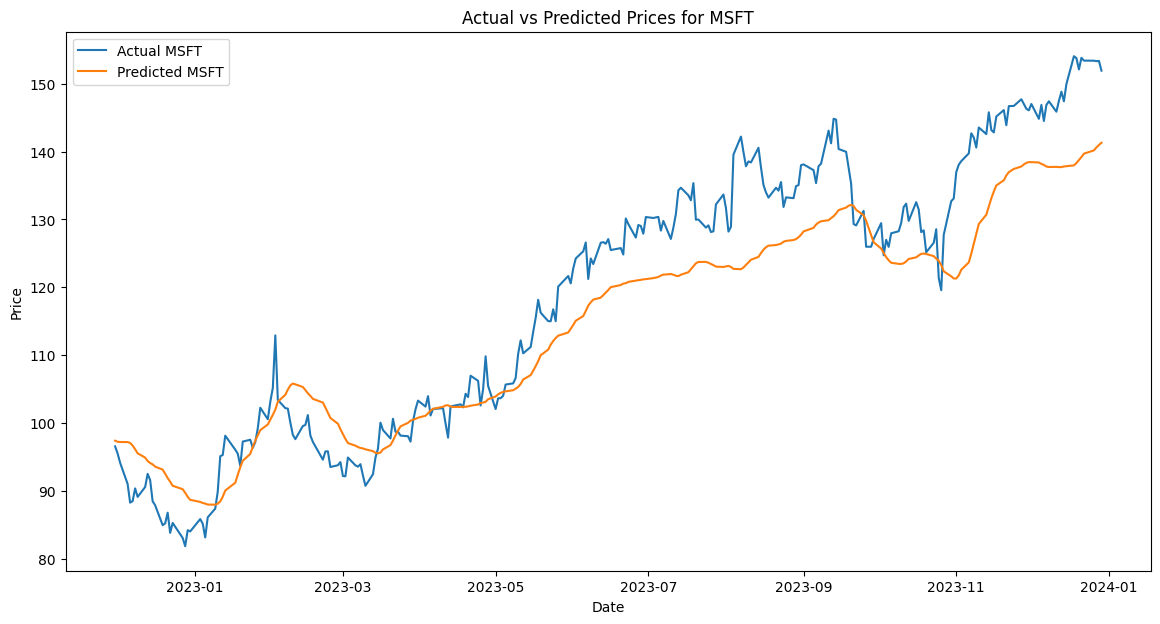

MSE for GOOGL: 69.8341


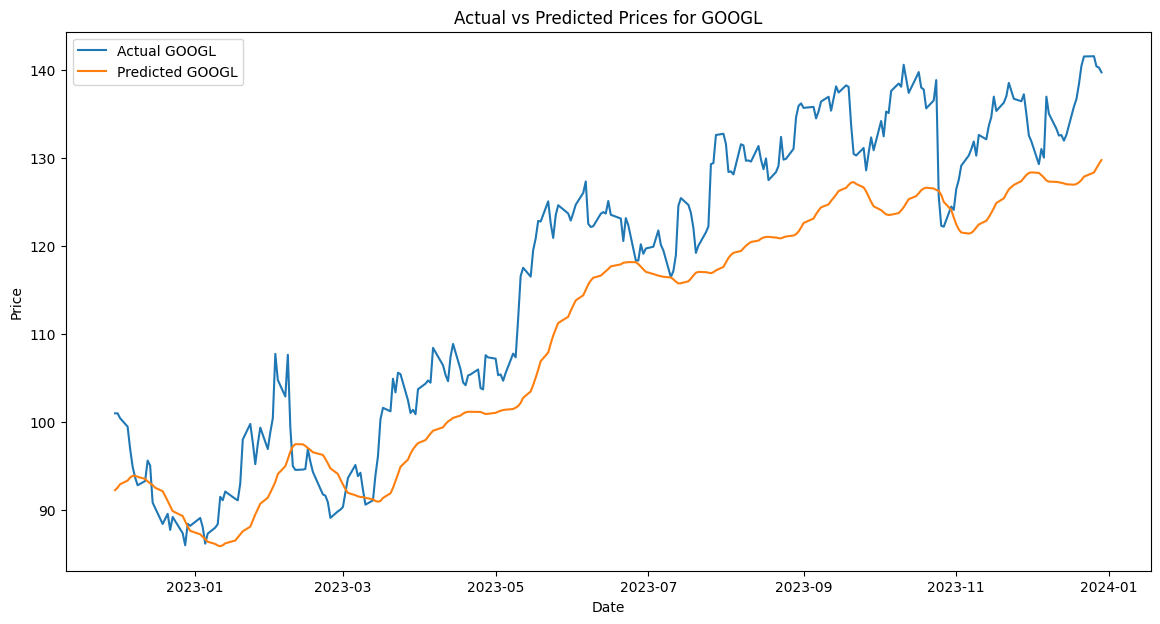

MSE for AMZN: 1403.9406


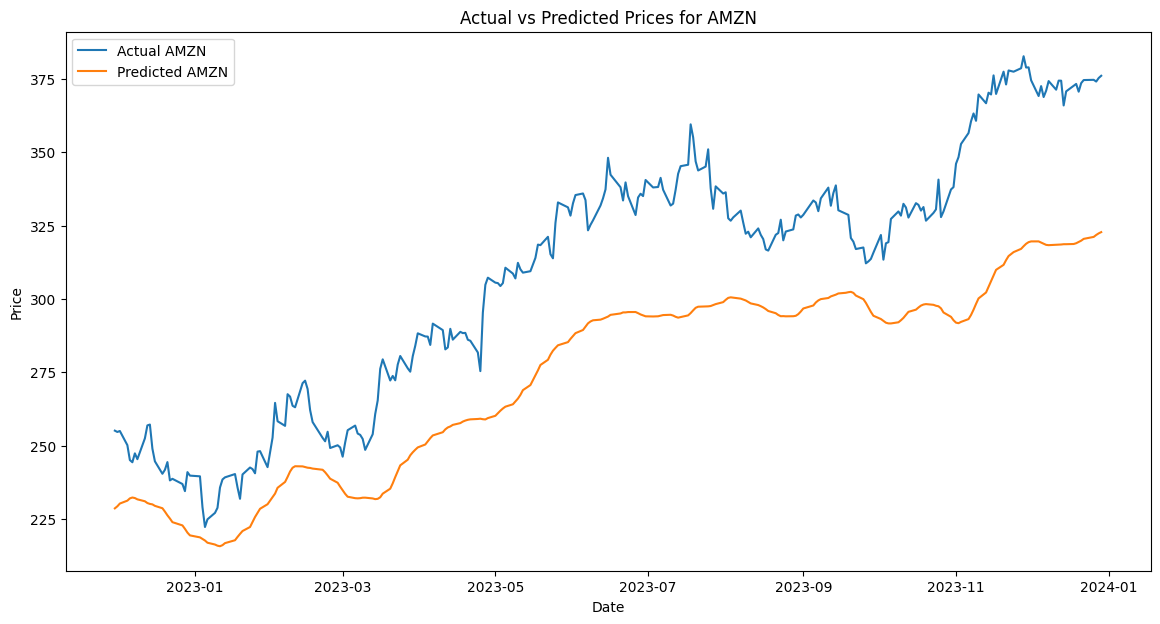

MSE for TSLA: 571.9596


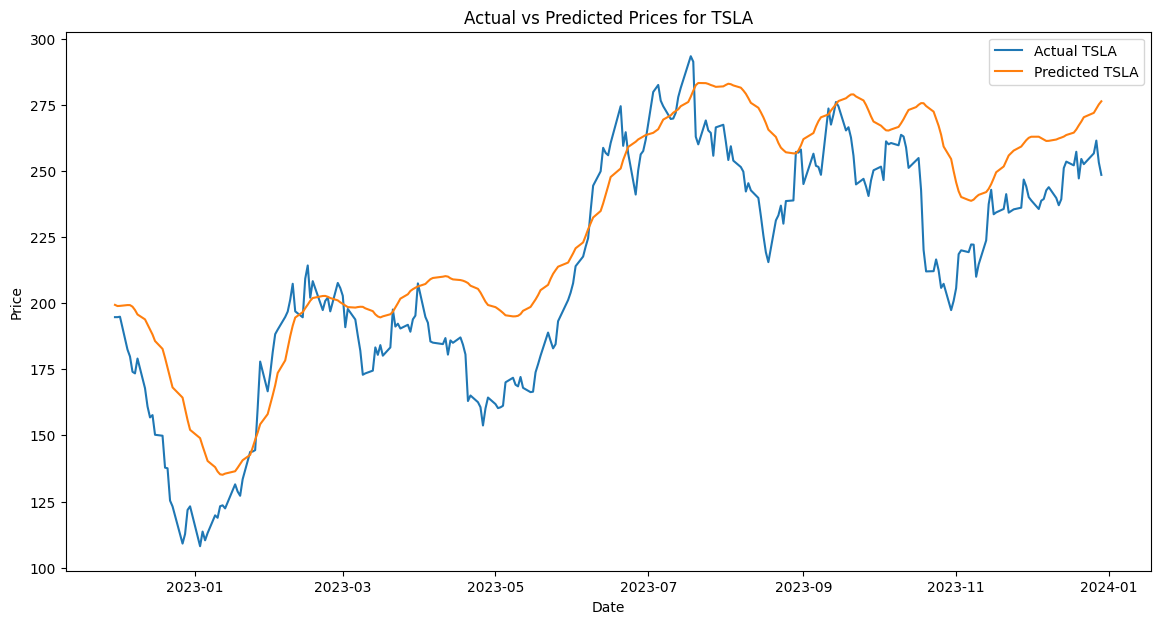

In [19]:
# Predict using the LSTM model
predicted_stock_prices = model.predict(X_test)

# Inverse transform the predictions and actual data
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)
Y_test_actual = scaler.inverse_transform(Y_test)

mse_values = {}

# Plot actual vs predicted prices for each stock
for i, stock in enumerate(stocks):
    # Calculate MSE for the stock
    mse = mean_squared_error(Y_test_actual[:, i], predicted_stock_prices[:, i])
    mse_values[stock] = mse
    
    # Print the MSE for the stock
    print(f"MSE for {stock}: {mse:.4f}")
    
    # Plot actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(data_close.index[train_size + time_step:], Y_test_actual[:, i], label=f'Actual {stock}')
    plt.plot(data_close.index[train_size + time_step:], predicted_stock_prices[:, i], label=f'Predicted {stock}')
    plt.title(f'Actual vs Predicted Prices for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

Metric                   Optimal        Max/Min        
-------------------------------------------------------
Return                   0.3161         0.3402         
Std Deviation            0.0549         0.0549         
Sharpe Ratio             5.7633         5.7633         

Optimal Portfolio Weights:
AAPL: 7.86%
MSFT: 1.19%
GOOGL: 14.98%
AMZN: 74.95%
TSLA: 1.03%


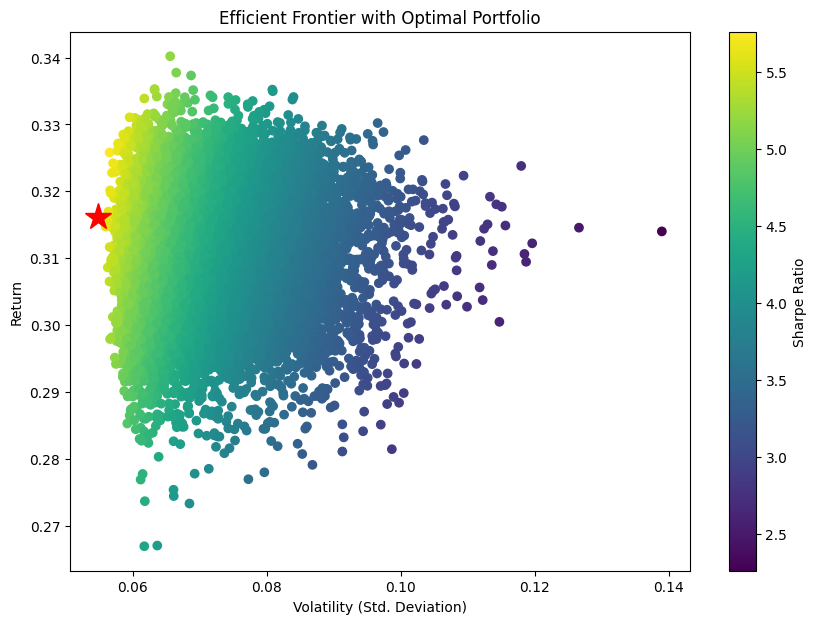

In [16]:
#  Calculate returns from the predicted prices
predicted_returns = pd.DataFrame(predicted_stock_prices, columns=stocks).pct_change().dropna()

# Mean returns and covariance matrix from predicted returns
mean_returns = predicted_returns.mean()
cov_matrix = predicted_returns.cov()

# Number of portfolios to simulate
num_portfolios = 10000# Store results
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = results[0, i] / results[1, i]  # Sharpe Ratio
    weights_record.append(weights)

# Locate the portfolio with the highest Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_stddev = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Print the Sharpe Ratio and Portfolio Weights
print(f"{'Metric':<25}{'Optimal':<15}{'Max/Min':<15}")
print("-" * 55)
print(f"{'Return':<25}{results[0, max_sharpe_idx]:<15.4f}{max(results[0, :]):<15.4f}")
print(f"{'Std Deviation':<25}{results[1, max_sharpe_idx]:<15.4f}{min(results[1, :]):<15.4f}")
print(f"{'Sharpe Ratio':<25}{results[2, max_sharpe_idx]:<15.4f}{max(results[2, :]):<15.4f}")

print("\nOptimal Portfolio Weights:")
for stock, weight in zip(stocks, max_sharpe_weights):
    print(f"{stock}: {weight:.2%}")

# Display the portfolio as a DataFrame
portfolio = pd.DataFrame({
    'Stock': stocks,
    'Weight': max_sharpe_weights
})

portfolio['Weight'] = portfolio['Weight'].apply(lambda x: f"{x:.2%}")
# print(portfolio)

# Plot Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.plot(max_sharpe_stddev, max_sharpe_return, marker='*', color='r', ms=20)  # Highlight max Sharpe portfolio
plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')

# Add a color bar with the correct range
# sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
# sm.set_array([])
plt.colorbar(label='Sharpe Ratio')

plt.show()